# Inference of the deployed model

This notebook shows how to perform inferencing of the deployed model on Vertex AI platform. It is divided into two sections.
- Inference on locally saved model
  - Download the model artifact from the Vertex Pipeline, inspect the SavedModel, load the SavedModel, run inference.
- Inference on Vertex Endpoint
  - Convert base64 encoded images, run inference.

**NOTE**: The semantic segmentation prediction doesn't look good on this notebook. This is because the purpose of this notebook is not about showing the result from the nicely fine-tuned model but demonstrating how to perform inferences of the model from the Vertex Pipeline.

# Inference on locally saved model

## Download trained model

the following CLI downloads a SavedModel from Vertex Pipeline to the local file system. This is to inspect the saved model from the Vertex Pipeline.

In [45]:
!mkdir ./tmp
!gsutil -m cp -r \
  "gs://gcp-ml-172005-complete-mlops/tfx_pipeline_output/segformer-training-pipeline/874401645461/segformer-training-pipeline-20220910042819/Trainer_-9039145015330209792/model/Format-Serving" \
  ./tmp

mkdir: cannot create directory ‘./tmp’: File exists
Copying gs://gcp-ml-172005-complete-mlops/tfx_pipeline_output/segformer-training-pipeline/874401645461/segformer-training-pipeline-20220910042819/Trainer_-9039145015330209792/model/Format-Serving/keras_metadata.pb...
Copying gs://gcp-ml-172005-complete-mlops/tfx_pipeline_output/segformer-training-pipeline/874401645461/segformer-training-pipeline-20220910042819/Trainer_-9039145015330209792/model/Format-Serving/saved_model.pb...
Copying gs://gcp-ml-172005-complete-mlops/tfx_pipeline_output/segformer-training-pipeline/874401645461/segformer-training-pipeline-20220910042819/Trainer_-9039145015330209792/model/Format-Serving/variables/variables.data-00000-of-00001...
Copying gs://gcp-ml-172005-complete-mlops/tfx_pipeline_output/segformer-training-pipeline/874401645461/segformer-training-pipeline-20220910042819/Trainer_-9039145015330209792/model/Format-Serving/variables/variables.index...


## Move downloaded model to `model` directory

In [46]:
model_path = "model"

!mkdir {model_path}
!cp -r tmp/Format-Serving/* {model_path}/

mkdir: cannot create directory ‘model’: File exists


## Inspect the signatures of the model

Note the name of signature of the inputs `string_input`
- This will be the key of the input data when performing inference on Vertex Endpoint.
- The input data should be base64 encoded images

In [47]:
!saved_model_cli show --dir {model_path} --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['string_input'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_string_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['seg_mask'] tensor_info:
      dtype: DT_INT64
      shape: (-1, 128, 128)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


## Load model

In [48]:
import tensorflow as tf

model = tf.keras.models.load_model(model_path)

## Run prediction on a single image

### Load sidewalk dataset

In [49]:
test_image_path = tf.keras.utils.get_file(
    "test-image.jpg", "https://i.ibb.co/whmGJr4/test-image.jpg"
)

test_label_path = tf.keras.utils.get_file(
    "gt-image.jpg", "https://i.ibb.co/nDg4Pxv/test-gt.jpg"
)

### Get a test image

In [51]:
import numpy as np

with open(test_image_path, "rb") as f:
    test_image = f.read()

with open(test_label_path, "rb") as f:
    gt_image = f.read()    

test_image = tf.io.decode_jpeg(test_image, channels=3)
test_gt = tf.io.decode_jpeg(gt_image, channels=1)

test_image = tf.image.resize(test_image, (128, 128))
test_image = test_image / 255
test_gt = tf.image.resize(test_gt, (128, 128))

input_numpy = np.array(test_image)
input_tensor = tf.convert_to_tensor(input_numpy)
input_tensor = input_tensor[tf.newaxis, ...]

### Get prediction (Logit)

In [52]:
prediction = model.predict(input_tensor)
print(prediction.shape)

seg_mask = tf.math.argmax(prediction, -1)
seg_mask = tf.squeeze(seg_mask)
print(seg_mask.shape)

(1, 128, 128, 35)
(128, 128)


### Visualize the result

In [53]:
def sidewalk_palette():
    """Sidewalk palette that maps each class to RGB values."""
    return [
        [0, 0, 0],
        [216, 82, 24],
        [255, 255, 0],
        [125, 46, 141],
        [118, 171, 47],
        [161, 19, 46],
        [255, 0, 0],
        [0, 128, 128],
        [190, 190, 0],
        [0, 255, 0],
        [0, 0, 255],
        [170, 0, 255],
        [84, 84, 0],
        [84, 170, 0],
        [84, 255, 0],
        [170, 84, 0],
        [170, 170, 0],
        [170, 255, 0],
        [255, 84, 0],
        [255, 170, 0],
        [255, 255, 0],
        [33, 138, 200],
        [0, 170, 127],
        [0, 255, 127],
        [84, 0, 127],
        [84, 84, 127],
        [84, 170, 127],
        [84, 255, 127],
        [170, 0, 127],
        [170, 84, 127],
        [170, 170, 127],
        [170, 255, 127],
        [255, 0, 127],
        [255, 84, 127],
        [255, 170, 127],
    ]

In [54]:
def get_seg_overlay(image, seg):
    color_seg = np.zeros(
        (seg.shape[0], seg.shape[1], 3), dtype=np.uint8
    )  # height, width, 3
    palette = np.array(sidewalk_palette())
    # print(image.shape)
    # print(seg.shape)
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    return img

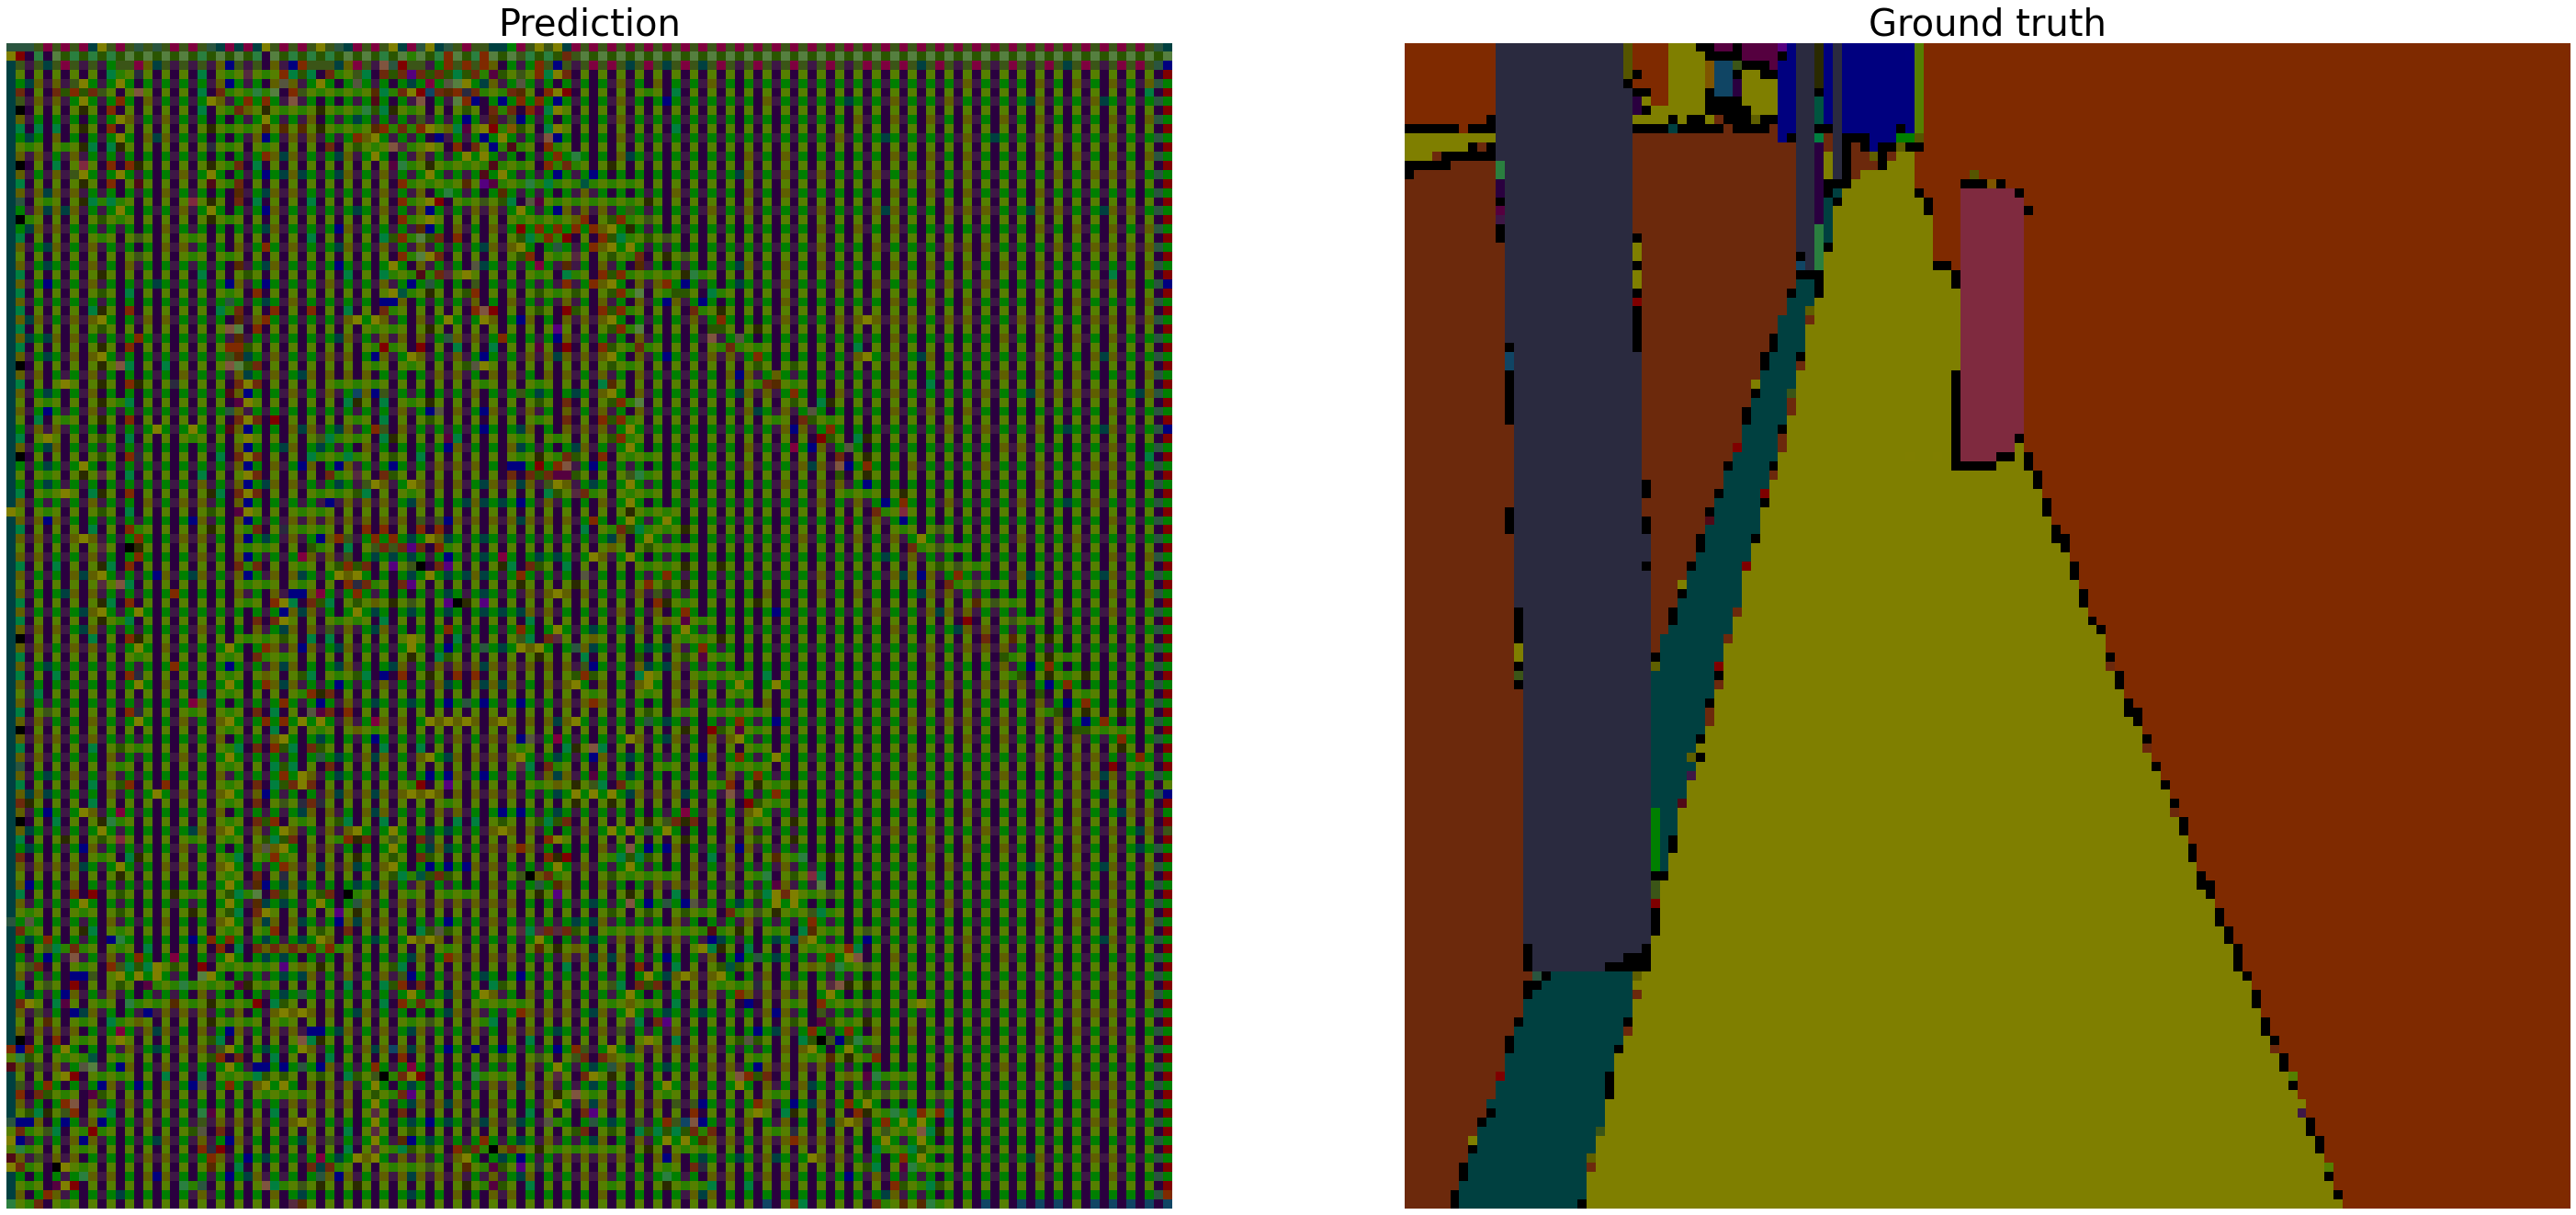

In [55]:
import matplotlib.pyplot as plt

pred_img = get_seg_overlay(test_image, seg_mask.numpy())
test_gt = tf.squeeze(test_gt)
gt_img = get_seg_overlay(test_image, np.array(test_gt))

f, axs = plt.subplots(1, 2)
f.set_figheight(30)
f.set_figwidth(50)

axs[0].set_title("Prediction", {"fontsize": 40})
axs[0].imshow(pred_img)
axs[0].axis("off")
axs[1].set_title("Ground truth", {"fontsize": 40})
axs[1].imshow(gt_img)
axs[1].axis("off")

plt.show()

NOTE: The reason why the visualization output looks pixelated on the ground truth is that the size of the original image is reduced to (128, 128). Also, note that the prediction result is not so good since we are using a model trained for a very short period of time.

# Inference on Vertex Endpoint

## Setup

In [56]:
import google.auth # pip install -U google-auth
from google.auth.transport.requests import AuthorizedSession

import tensorflow as tf 
import base64
import json

In [57]:
PROJECT_ID = "gcp-ml-172005"
REGION = "us-central1"
ENDPOINT_ID = "7762226636656738304"

In [58]:
!gcloud auth application-default login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fapplicationdefaultauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=3TjXUU3UiHEWTmVyPBI0mQ1z09ikZM&prompt=consent&access_type=offline&code_challenge=GbcOjwEYYq-_12Vf0NAFdw985fIfSq72xOei7YdsuLw&code_challenge_method=S256

Enter authorization code: 4/0AdQt8qiUFTX9Ct9Z9kQXs0H9v8vWpd1gCTpGPT3G-7ycwFHuwIq0pd34brYqn3B4e4v1TA

Credentials saved to file: [/content/.config/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).
Cannot find a quota project to add to AD

In [59]:
credentials, _ = google.auth.default()
service_endpoint = f"https://{REGION}-aiplatform.googleapis.com"
authed_session = AuthorizedSession(credentials)

/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


## Construct Endpoint URL

In [60]:
url = "{}/v1/projects/{}/locations/{}/endpoints/{}:predict".format(
    service_endpoint, PROJECT_ID, REGION, ENDPOINT_ID
)
print("Endpoint: ", url)

Endpoint:  https://us-central1-aiplatform.googleapis.com/v1/projects/gcp-ml-172005/locations/us-central1/endpoints/7762226636656738304:predict


## Prepare key/value of the prediction request

In [61]:
serving_input = list(
    model.signatures["serving_default"].structured_input_signature[1].keys()
)[0]
print("Serving function input:", serving_input)

Serving function input: string_input


In [63]:
with open(test_image_path, "rb") as f:
    image = f.read()

b64str = base64.urlsafe_b64encode(image).decode('utf-8')

## Construct prediction requests

In [64]:
single_instance_request_body = {
    "instances": [{serving_input: b64str}]
}

two_instances_request_body = {
    "instances": [
        {serving_input: b64str}, 
        {serving_input: b64str},
    ]
}

## Prediction with a single instance

In [65]:
response = authed_session.post(url, data=json.dumps(single_instance_request_body))
print(response)
print(response.content)

<Response [200]>
b'{\n  "predictions": [\n    [\n      [\n        26,\n        26,\n        26,\n        4,\n        32,\n        4,\n        32,\n        4,\n        32,\n        7,\n        2,\n        4,\n        32,\n        4,\n        26,\n        4,\n        26,\n        4,\n        32,\n        4,\n        32,\n        4,\n        26,\n        7,\n        32,\n        7,\n        32,\n        7,\n        2,\n        4,\n        32,\n        4,\n        32,\n        4,\n        2,\n        4,\n        26,\n        7,\n        32,\n        4,\n        32,\n        4,\n        2,\n        7,\n        32,\n        26,\n        2,\n        7,\n        26,\n        4,\n        32,\n        4,\n        4,\n        7,\n        7,\n        9,\n        32,\n        4,\n        2,\n        4,\n        2,\n        7,\n        32,\n        4,\n        32,\n        4,\n        32,\n        4,\n        32,\n        4,\n        32,\n        4,\n        32,\n        4,\n        32,\n        4,\

The `response.content` contains five keys
- `deployedModelId`: the ID to distinguished the deployed model from the model registry in Vertex AI
- `model`: the endpoint to interact with the model
- `modelDisplayName`: name of the model appearing in the Vertex AI dashboard
- `modelVersionId`: the version of the model
- `predictions`: the prediction from the request

You should parse the content the `response.content` from the request to interpret the prediction result. Since the type of `response.content` is `bytes`, we need to process it in the following steps:
1. decode `bytes` type to `string` type
2. parse to `dict` type since the prediction results in `response.content` is formed in JSON format
3. the actual prediction results are stored in `response.content['predictions']`. `response.content['predictions']` is a `list` type, and each entry/item is also a `list` type which contains a range of pixel values of the segmentation masks.
4. `tf.convert_to_tensor` has a capability to parse a list of values into `tf.Tensor`, so `tf.convert_to_tensor(response['predictions'])` will give you the `tf.Tensor` representation of the prediction results

In [66]:
import ast

response = response.content.decode('utf-8')
response = ast.literal_eval(response)

seg_mask = tf.convert_to_tensor(response['predictions'])
seg_mask = tf.squeeze(seg_mask)
seg_mask

<tf.Tensor: shape=(128, 128), dtype=int32, numpy=
array([[26, 26, 26, ...,  4, 26,  7],
       [20,  6, 24, ..., 31, 13, 31],
       [ 7,  4,  3, ...,  4, 26, 10],
       ...,
       [ 7, 17, 14, ..., 17, 24,  6],
       [ 7,  8, 24, ...,  9, 26, 18],
       [27, 17, 14, ..., 21, 24, 21]], dtype=int32)>

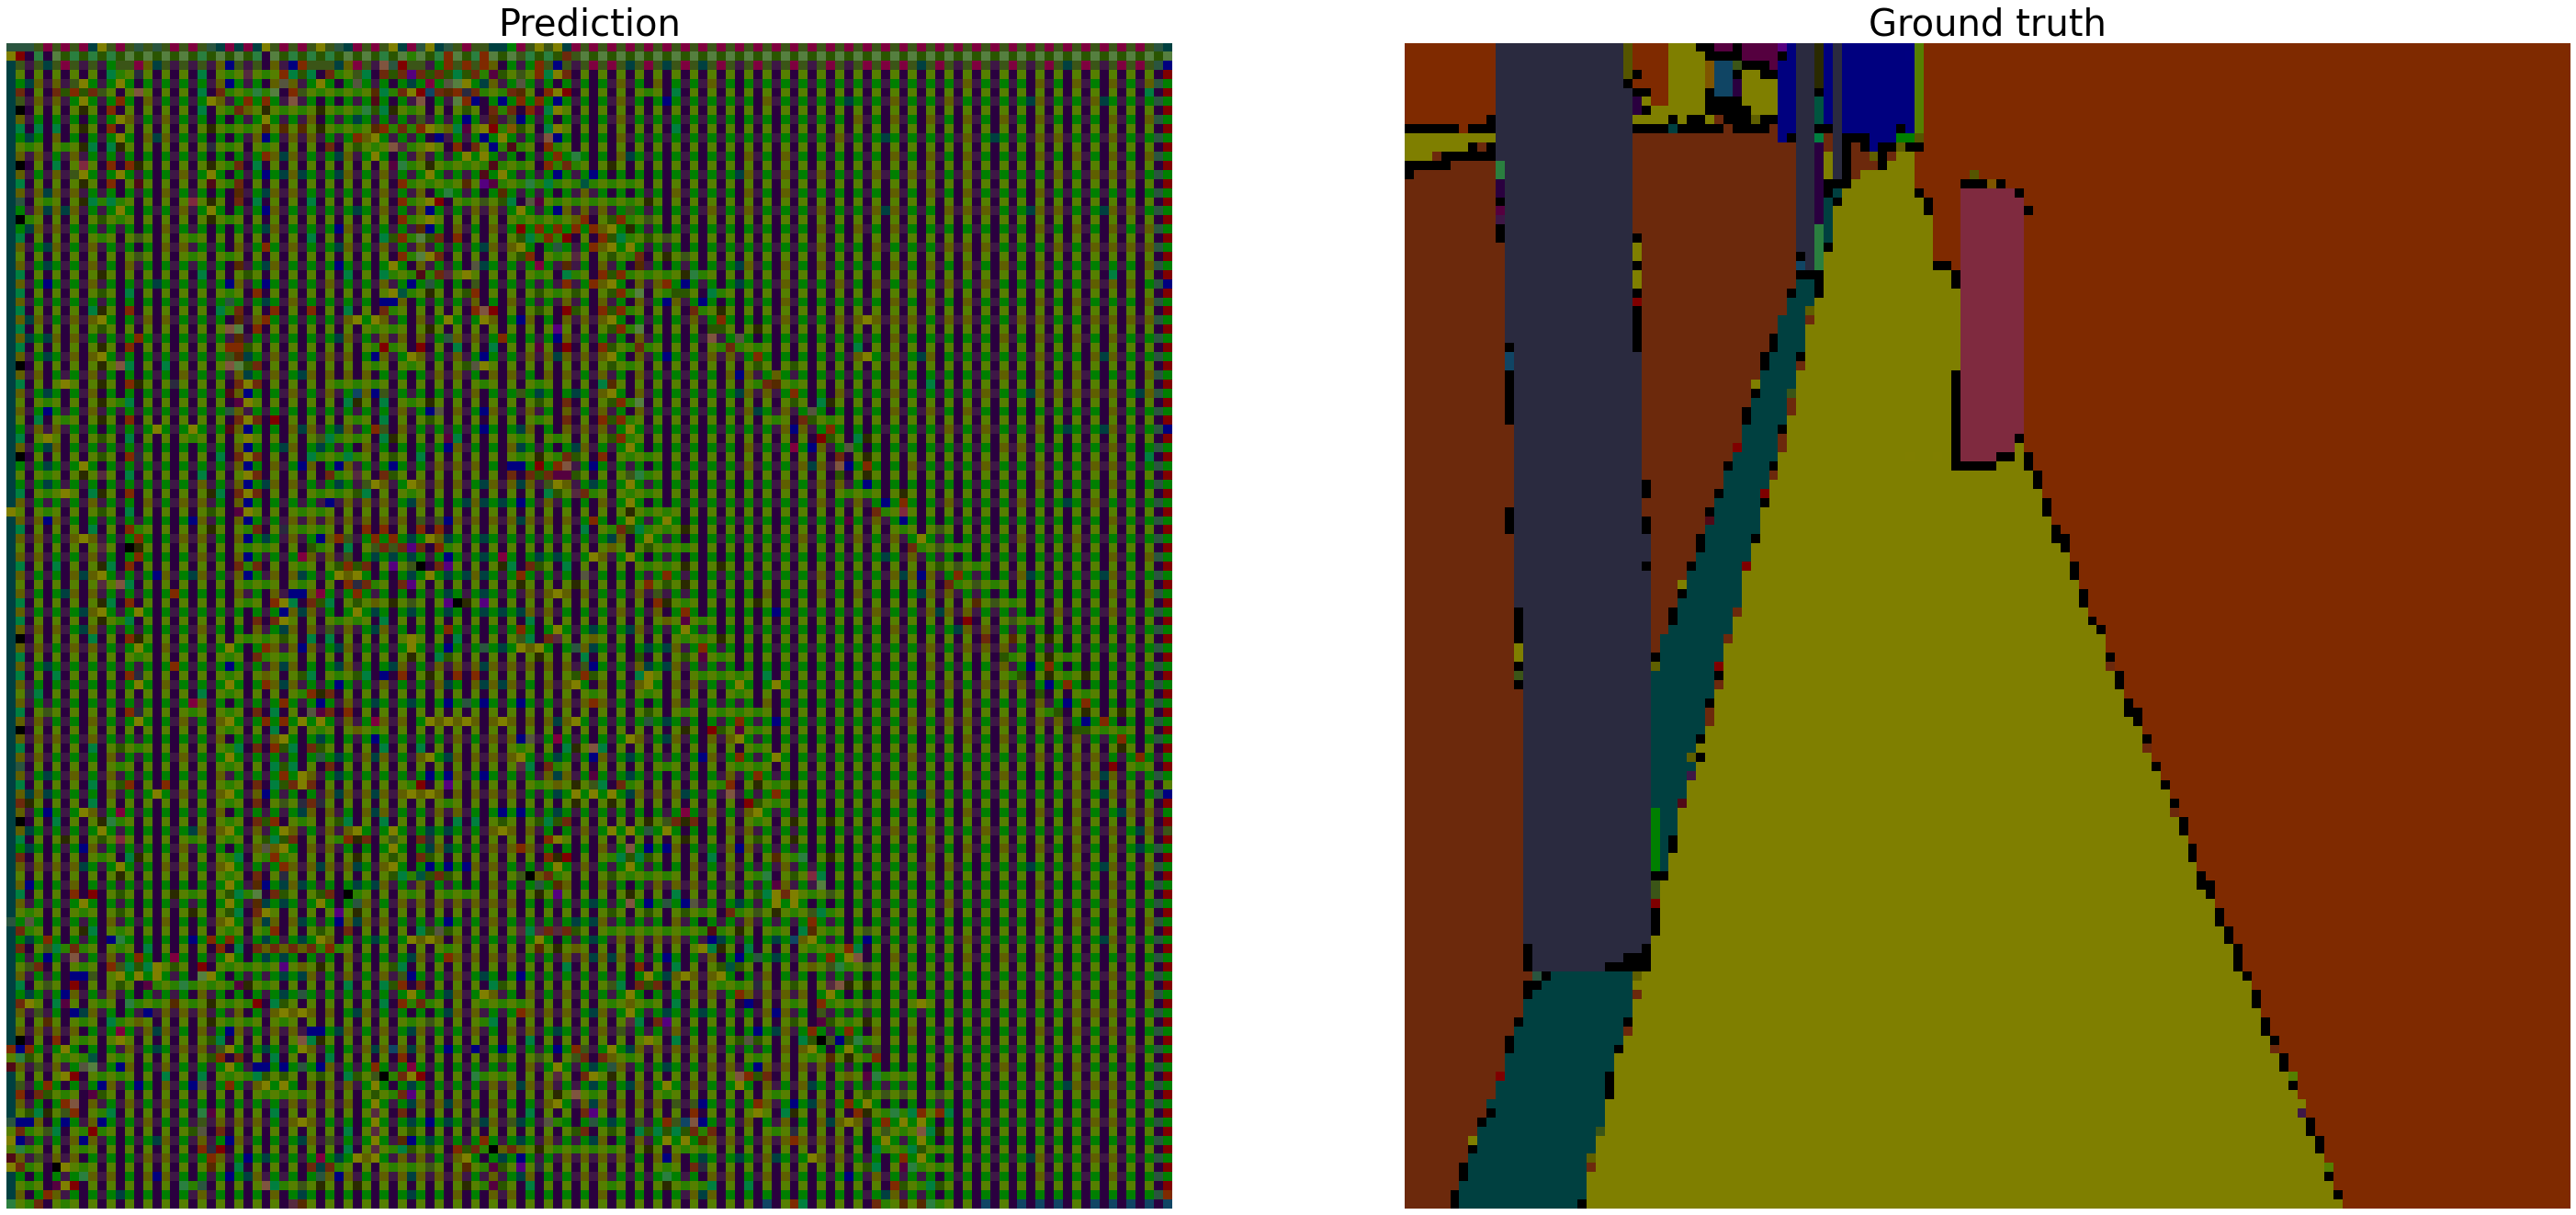

In [67]:
import matplotlib.pyplot as plt

pred_img = get_seg_overlay(test_image, seg_mask.numpy())
gt_img = get_seg_overlay(test_image, np.array(test_gt))

f, axs = plt.subplots(1, 2)
f.set_figheight(30)
f.set_figwidth(50)

axs[0].set_title("Prediction", {"fontsize": 40})
axs[0].imshow(pred_img)
axs[0].axis("off")
axs[1].set_title("Ground truth", {"fontsize": 40})
axs[1].imshow(gt_img)
axs[1].axis("off")

plt.show()

## Prediction with two instances

In [68]:
response = authed_session.post(url, data=json.dumps(two_instances_request_body))
print(response)
print(response.content)

<Response [200]>
b'{\n  "predictions": [\n    [\n      [\n        26,\n        26,\n        26,\n        4,\n        32,\n        4,\n        32,\n        4,\n        32,\n        7,\n        2,\n        4,\n        32,\n        4,\n        26,\n        4,\n        26,\n        4,\n        32,\n        4,\n        32,\n        4,\n        26,\n        7,\n        32,\n        7,\n        32,\n        7,\n        2,\n        4,\n        32,\n        4,\n        32,\n        4,\n        2,\n        4,\n        26,\n        7,\n        32,\n        4,\n        32,\n        4,\n        2,\n        7,\n        32,\n        26,\n        2,\n        7,\n        26,\n        4,\n        32,\n        4,\n        4,\n        7,\n        7,\n        9,\n        32,\n        4,\n        2,\n        4,\n        2,\n        7,\n        32,\n        4,\n        32,\n        4,\n        32,\n        4,\n        32,\n        4,\n        32,\n        4,\n        32,\n        4,\n        32,\n        4,\

In [69]:
response = response.content.decode('utf-8')
response = ast.literal_eval(response)

seg_mask = tf.convert_to_tensor(response['predictions'])
seg_mask = tf.squeeze(seg_mask)
seg_mask

<tf.Tensor: shape=(2, 128, 128), dtype=int32, numpy=
array([[[26, 26, 26, ...,  4, 26,  7],
        [20,  6, 24, ..., 31, 13, 31],
        [ 7,  4,  3, ...,  4, 26, 10],
        ...,
        [ 7, 17, 14, ..., 17, 24,  6],
        [ 7,  8, 24, ...,  9, 26, 18],
        [27, 17, 14, ..., 21, 24, 21]],

       [[26, 26, 26, ...,  4, 26,  7],
        [20,  6, 24, ..., 31, 13, 31],
        [ 7,  4,  3, ...,  4, 26, 10],
        ...,
        [ 7, 17, 14, ..., 17, 24,  6],
        [ 7,  8, 24, ...,  9, 26, 18],
        [27, 17, 14, ..., 21, 24, 21]]], dtype=int32)>